# Large Multichannel Timeseries

<img 
    src="./assets/large_multichan-ts.png" 
    alt="Large Multichannel Timeseries Workflow" 
    align="center" 
    style="border: 2px solid #ccc; border-radius: 8px; padding: 5px; width: 100%; box-shadow: 0px 4px 8px rgba(0,0,0,0.1);">


---

In [1]:
from IPython.display import HTML
HTML("""
<div style="display: flex; justify-content: center; padding: 10px;">
    <iframe width="560" height="315" src="https://www.youtube.com/embed/vC5E16ghlZA?si=sKAxgy2_2LRBqXrN" title="YouTube video player" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>
""")

---

## Prerequisites

| What? | Why? |
| --- | --- |
| [Index: Intro, Workflows, Extensions](./index.ipynb) | For context and workflow selection/feature guidance |
| [Recommended Workflow](./0_multichan.ipynb) | For live downsampling with in-memory Pandas DataFrame |

## Overview

For an introduction, please visit the ['Index'](./index.ipynb) page. This workflow is tailored for processing and analyzing large multichannel timeseries data derived from [electrophysiological](https://en.wikipedia.org/wiki/Electrophysiology) recordings. It is more experimental and complex than the recommended workflow but, at the time of writing, provides a scalable solution at the cutting edge of development.

### What Defines a 'Large-Sized' Dataset?

A 'large-sized' dataset in this context is characterized by its size surpassing the available memory, making it impossible to load the entire dataset into RAM simultaneously. So, how are we to visualize a zoomed-out representation of the entire large dataset?

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    To make this demo notebook more accessible and easier to run on most systems, we'll use a dataset that doesn't meet our own definition of 'large'—it likely fits entirely into your RAM. Despite this, the techniques and workflow demonstrated here are designed to handle much larger datasets that cannot be loaded into memory all at once.
</div>

### Utilizing a Large Multi-Resolution Data Pyramid

In the 'medium' workflow, we employed downsampling to reduce the volume of data transferred to the browser, a technique feasible when the entire dataset already resides in memory. For larger datasets, however, we now adopt an additional strategy: the creation and dynamic access to a data pyramid. A multi-resolution data pyramid involves storing multiple layers of the dataset at varying resolutions, where each successive layer is a downsampled version of the previous one. For instance, when fully zoomed out, a greatly downsampled version of the data provides a quick overview, guiding users to areas of interest. Upon zooming in, tiles of higher-resolution pyramid levels are dynamically loaded. This strategy outlined is similar to the approach used in geosciences for managing interactive map tiles, and which has also been adopted in bio-imaging for handling high-resolution electron microscopy images. 

### Key Software:

Alongside [HoloViz](https://github.com/holoviz), [Bokeh](https://holoviz.org/), and [Numpy](https://numpy.org/), we make extensive use of several open source libraries to implement our solution:
- **[Xarray](https://github.com/pydata/xarray):** Manages labeled multi-dimensional data, facilitating complex data operations and enabling partial data loading for out-of-core computation.
- **[Xarray DataTree](https://github.com/xarray-contrib/datatree):** Organizes xarray DataArrays and Datasets into a logical tree structure, making it easier to manage and access different resolutions of the dataset. At the moment of writing, this is [actively being migrated](https://github.com/pydata/xarray/issues/8572) into the core Xarray library.
- **[Dask](https://github.com/dask/dask):** Adds parallel computing capabilities, managing tasks that exceed memory limits.
- **[ndpyramid](https://github.com/carbonplan/ndpyramid):** Specifically designed for creating multi-resolution data pyramids.
- **[Zarr](https://github.com/zarr-developers/zarr-python):** Used for storing the large arrays of the data pyramid on disk in a compressed, chunked, and memory-mappable format, which is crucial for efficient data retrieval.
- **[tsdownsample](https://github.com/predict-idlab/tsdownsample):** Provides optimized implementations of downsampling algorithms that help to maintain important aspects of the data.

### Considerations and Trade-offs
While this approach allows visualization and interaction with datasets larger than available memory, it does introduce certain trade-offs:

- **Increased Storage Requirement:** Constructing a data pyramid currently requires additional disk space since multiple representations of the data are stored.
- **Code Complexity:** Creating the pyramids still involves a fair bit of familiarity with the key packages, and their interoperability. Also, the plotting code involved in dynamic access to the data pyramid structure could be matured into HoloViz or another codebase in the future.
- **Performance:** While this method can handle large datasets, the performance may not match that of handling smaller datasets due to the overhead associated with processing and dynamically loading multiple layers of the pyramid.

---

## Imports and Configuration

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
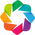

In [2]:
from pathlib import Path
from IPython.display import display

import dask.array as da
import h5py
import holoviews as hv
import numpy as np
import panel as pn
import pooch
import xarray as xr
from ndpyramid import pyramid_create
from tsdownsample import MinMaxLTTBDownsampler
from xarray.backends.api import open_datatree  # until API stabilizes

hv.extension("bokeh")
pn.extension()

In [3]:
DATA_URL = 'https://datasets.holoviz.org/lfp/v1/sub-719828686_ses-754312389_probe-756781563_ecephys.nwb'
DATA_DIR = Path('./data')
DATA_FILENAME = Path(DATA_URL).name
DATA_PATH = DATA_DIR / DATA_FILENAME
PYRAMID_FILE = f"{DATA_PATH.stem}.zarr"
PYRAMID_PATH = DATA_DIR / PYRAMID_FILE

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    If you are viewing this notebook as a result of using the `anaconda-project run` command, the data has already been ingested, as configured in the associated yaml file. Running the following cell should find that data and skip any further download.
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    If not already downloaded (e.g. via the `anaconda-project run` command) the following cell will download ~900 MB the first time it is run.
</div>

In [4]:
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Download the data if it doesn't exist
if not DATA_PATH.exists():
    print(f'Downloading data to: {DATA_PATH}')
    pooch.retrieve(
        url=DATA_URL,
        known_hash=None,
        fname=DATA_FILENAME,
        path=DATA_DIR,
        progressbar=True,
    )
else:
    print(f'Data exists at: {DATA_PATH}')

Data exists at: data/sub-719828686_ses-754312389_probe-756781563_ecephys.nwb


## Inspecting the Raw File

In order to select the relevant parts of the original dataset that we are interested in, we first have to figure out where they are in the database. The original NWB (HDF5) file format is like a file-system within a file. According to the [NWB docs](https://nwb-overview.readthedocs.io/en/latest/intro_to_nwb/2_file_structure.html#file-hierarchy), we should find the data in either the '`/acquisition`' or '`processing`' path groups. Let's write a function to quickly display everything in those groups. We are looking for 'LFP' data which will be a 2D array and the corresponding LFP data dimension vectors (time, electrodes).

In [5]:
def print_hdf5_keys(filename, path='/'):
    """Prints all keys (paths) in an HDF5 file."""
    with h5py.File(filename, 'r') as f:
        for key in f[path].keys():
            full_path = f"{path}/{key}" if path != '/' else key
            print(full_path)
            if isinstance(f[full_path], h5py.Group):
                print_hdf5_keys(filename, full_path)

In [6]:
print_hdf5_keys(DATA_PATH, path='/processing')
print_hdf5_keys(DATA_PATH, path='/acquisition')

/processing/current_source_density
/processing/current_source_density/ecephys_csd
/processing/current_source_density/ecephys_csd/current_source_density
/processing/current_source_density/ecephys_csd/current_source_density/data
/processing/current_source_density/ecephys_csd/current_source_density/timestamps
/processing/current_source_density/ecephys_csd/virtual_electrode_x_positions
/processing/current_source_density/ecephys_csd/virtual_electrode_y_positions
/acquisition/probe_756781563_lfp
/acquisition/probe_756781563_lfp/probe_756781563_lfp_data
/acquisition/probe_756781563_lfp/probe_756781563_lfp_data/data
/acquisition/probe_756781563_lfp/probe_756781563_lfp_data/electrodes
/acquisition/probe_756781563_lfp/probe_756781563_lfp_data/timestamps
/acquisition/probe_756781563_lfp_data
/acquisition/probe_756781563_lfp_data/data
/acquisition/probe_756781563_lfp_data/electrodes
/acquisition/probe_756781563_lfp_data/timestamps


It looks like our LFP `data` key is in `acquisition/probe_810755797_lfp_data`, along with the `electrodes` and `timestamps` dimensions. Don't worry about the multiple `lfp.../data` files, these paths point to the same underlying object. Let's note down the paths to our data objects of interest:

In [7]:
DATA_KEY = "acquisition/probe_756781563_lfp_data/data"
DATA_DIMS = {"time": "acquisition/probe_756781563_lfp_data/timestamps",
             "channel": "acquisition/probe_756781563_lfp_data/electrodes",
            }

## Creating an Intermediate `Xarray` Dataset

Before building a data pyramid, we'll first we construct an `Xarray` version of our dataset from its original NWB (HDF5) format. We'll make use of `Dask` for parallel and 'lazy' computation, i.e. chunks of the data are only loaded when necessary, enabling operations on data that exceed memory limits. An impactful goal for future work would be to create the data pyramid directly from original NWB (HDF5) file and skip creation of this intermediate version.

In [8]:
def convert_to_xarray(f, data_key, dims):
    """Convert HDF5 data into an xarray Dataset with lazy loading."""
    # Extract coordinates for the specified dimensions
    coords = {dim: f[coord_key][:] for dim, coord_key in dims.items()}
    
    # Load the dataset lazily using Dask. Chunk per channel for downsampling.
    data = f[data_key]
    dask_data = da.from_array(data, chunks=(data.shape[0], 1))
    
    # Create the xarray DataArray and convert it to a Dataset
    data_array = xr.DataArray(
        dask_data,
        dims=list(dims.keys()),
        coords=coords,
        name=data_key.split("/")[-1]
    )
    ds = data_array.to_dataset(name='data')
    return ds

In [9]:
f = h5py.File(DATA_PATH, "r")
ts_ds = convert_to_xarray(f, DATA_KEY, DATA_DIMS)
ts_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 12094337, channel: 35)
Coordinates:
  * time     (time) float64 97MB 3.677 3.677 3.678 ... 9.679e+03 9.679e+03
  * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
Data variables:
    data     (time, channel) float32 2GB dask.array<chunksize=(12094337, 1), meta=np.ndarray>

## Building a Multi-Resolution Data Pyramid

We will feed our new `Xarray` data to `ndpyramid.pyramid_create`, also passing in the dimension that we want downsampled ('`time`'), a custom `apply_downsample` function that uses `xarray.apply_ufunc` to perform computations in a vectorized and parallelized manner, and `FACTORS` which determine the extent of each downsampled level. For instance, a factor of '2' halves the number of time samples, '4' reduces them to a quarter, and so on.

To each chunk of data, our custom `apply_downsample` function applies the `MinMaxLTTBDownsampler` from the `tsdownsample` library, which selects data points that best represent the overall shape of the signal. This method is particularly effective in preserving the visual integrity of the data, even at reduced resolutions. This may take some time depending on the amount of data.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Ensure you have sufficient disk space to handle the new data pyramid prior to running this section. If using the demo data, this will create a ~3 GB file on disk.
</div>

In [10]:
%%time

# The FACTORS will depend on the size of your dataset, available disk size, and the resolution needed
# For this demo, we are arbitrarily choosing 8 levels and scaling by quadrupling each preceding factor.
FACTORS = [4**i for i in range(8)]

def help_downsample(data, time, n_out):
    """
    Helper function for downsampling and returning as a specific format.
    """
    indices = MinMaxLTTBDownsampler().downsample(time, data, n_out=n_out)
    return data[indices], indices


def apply_downsample(ts_ds, factor, dims):
    """
    Apply downsampling to a time series dataset.
    """
    dim = dims[0]
    n_out = len(ts_ds["data"]) // factor
    print(f"Downsampling by factor {factor} for a size of {n_out}.")
    ts_ds_downsampled, indices = xr.apply_ufunc(
        help_downsample,
        ts_ds["data"],
        ts_ds[dim],
        kwargs=dict(n_out=n_out),
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim], ["indices"]],
        exclude_dims=set((dim,)),
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs=dict(output_sizes={dim: n_out, "indices": n_out}),
    )
    # Update the dimension coordinates with the downsampled indices
    ts_ds_downsampled[dim] = ts_ds[dim].isel(time=indices.values[0])
    return ts_ds_downsampled.rename("data")


if not PYRAMID_PATH.exists():
    print(f'Creating Pyramid: {PYRAMID_PATH}')
    ts_dt = pyramid_create(
        ts_ds,
        factors=FACTORS,
        dims=["time"],
        func=apply_downsample,
        type_label="pick",
        method_label="pyramid_downsample",
    )
    display(ts_dt)
else:
    print(f'Pyramid Already Exists: {PYRAMID_PATH}')

Creating Pyramid: data/sub-719828686_ses-754312389_probe-756781563_ecephys.zarr
Downsampling by factor 1 for a size of 12094337.


Downsampling by factor 4 for a size of 3023584.


Downsampling by factor 16 for a size of 755896.


Downsampling by factor 64 for a size of 188974.


Downsampling by factor 256 for a size of 47243.


Downsampling by factor 1024 for a size of 11810.


Downsampling by factor 4096 for a size of 2952.


Downsampling by factor 16384 for a size of 738.


DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0'}, {'path': '1'}, {'path': '2'},...
├── DataTree('0')
│       Dimensions:  (channel: 35, time: 12094337)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 97MB 3.677 3.677 3.678 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 2GB dask.array<chunksize=(1, 12094337), meta=np.ndarray>
├── DataTree('1')
│       Dimensions:  (channel: 35, time: 3023584)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 24MB 3.677 3.68 3.682 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 423MB dask.array<chunksize=(1, 3023584), meta=np.ndarray>
├── DataTree('2')
│       Dimensions:  (channel: 35, time: 755896)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 6MB 3.677 3.689 3.694 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 106MB dask.array<chunksize=(1, 755896), meta=np.ndarray>
├── DataTree('3')
│       Dimensions:  (channel: 35, time: 188974)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 2MB 3.677 3.701 3.777 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 26MB dask.array<chunksize=(1, 188974), meta=np.ndarray>
├── DataTree('4')
│       Dimensions:  (channel: 35, time: 47243)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 378kB 3.677 3.836 3.959 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 7MB dask.array<chunksize=(1, 47243), meta=np.ndarray>
├── DataTree('5')
│       Dimensions:  (channel: 35, time: 11810)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 94kB 3.677 3.959 4.748 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 2MB dask.array<chunksize=(1, 11810), meta=np.ndarray>
├── DataTree('6')
│       Dimensions:  (channel: 35, time: 2952)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 24kB 3.677 4.748 7.317 ... 9.677e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 413kB dask.array<chunksize=(1, 2952), meta=np.ndarray>
└── DataTree('7')
        Dimensions:  (channel: 35, time: 738)
        Coordinates:
          * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
          * time     (time) float64 6kB 3.677 7.468 22.72 ... 9.665e+03 9.679e+03
        Data variables:
            data     (channel, time) float32 103kB dask.array<chunksize=(1, 738), meta=np.ndarray>

CPU times: user 1min 4s, sys: 6.16 s, total: 1min 10s
Wall time: 51.1 s


### Save the Pyramid

Now we can easily persist the multi-level pyramid `to_zarr` format on disk. This may take some time depending on the amount of data.

In [11]:
%%time

if not PYRAMID_PATH.exists():
    PYRAMID_PATH.parent.mkdir(parents=True, exist_ok=True)
    ts_dt.to_zarr(PYRAMID_PATH, mode="w")
f.close()

CPU times: user 1min 4s, sys: 7.09 s, total: 1min 12s
Wall time: 49.5 s


## Dynamic Multi-Resolution Data Pyramid Plotting

Now that we've created our data pyramid, we can set up the interactive visualization.

Let's start fresh and get a handle to the data pyramid that we've saved to disk, making sure to specify the `zarr` engine.

In [12]:
ts_dt = open_datatree(PYRAMID_PATH, engine="zarr")
ts_dt

<xarray.DataTree>
Group: /
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0'}, {'path': '1'}, {'path': '2'},...
├── Group: /0
│       Dimensions:  (channel: 35, time: 12094337)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 97MB 3.677 3.677 3.678 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 2GB ...
├── Group: /1
│       Dimensions:  (channel: 35, time: 3023584)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 24MB 3.677 3.68 3.682 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 423MB ...
├── Group: /2
│       Dimensions:  (channel: 35, time: 755896)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 6MB 3.677 3.689 3.694 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 106MB ...
├── Group: /3
│       Dimensions:  (channel: 35, time: 188974)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 2MB 3.677 3.701 3.777 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 26MB ...
├── Group: /4
│       Dimensions:  (channel: 35, time: 47243)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 378kB 3.677 3.836 3.959 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 7MB ...
├── Group: /5
│       Dimensions:  (channel: 35, time: 11810)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 94kB 3.677 3.959 4.748 ... 9.679e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 2MB ...
├── Group: /6
│       Dimensions:  (channel: 35, time: 2952)
│       Coordinates:
│         * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
│         * time     (time) float64 24kB 3.677 4.748 7.317 ... 9.677e+03 9.679e+03
│       Data variables:
│           data     (channel, time) float32 413kB ...
└── Group: /7
        Dimensions:  (channel: 35, time: 738)
        Coordinates:
          * channel  (channel) int64 280B 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34
          * time     (time) float64 6kB 3.677 7.468 22.72 ... 9.665e+03 9.679e+03
        Data variables:
            data     (channel, time) float32 103kB ...

If you expand the 'Group' dropdown above, you can see each pyramid level has the same number of channels, but different number of timestamps, since the time dimension was downsampled.

### Prepare the Data

First, we will prepare some metadata needed for plotting and define a helper function to extract a dataset at a specific pyramid level and channel.

In [13]:
def extract_ds(ts_dt, level, channels=None):
    """Extract a dataset at a specific level"""
    ds = ts_dt[str(level)].ds
    return ds if channels is None else ds.sel(channel=channels)

# Grab the timestamps from the coursest level of the datatree for initialization
num_levels = len(ts_dt)
coarsest_level = str(num_levels-1)
time_da = extract_ds(ts_dt, coarsest_level)["time"]
channels = ts_dt[coarsest_level].ds["channel"].values
num_channels = len(channels)

### Create Dynamic Plot

Now for the main show, we'll utilize a HoloViews `DynamicMap` which will call a custom function called `rescale` whenever there is a change in the visible axes' ranges (`RangeXY`) or the size of a plot (`PlotSize`).

When the `rescale` function is triggered, it will first determine which pyramid `zoom_level` has the next closest number of data samples in the visible time range (`time_slice`) compared with the number of horizontal pixels on the screen.

Depending on the determined `zoom_level`, data corresponding to the visible time range is fetched through the `extract_ds` function, which accesses the specific slice of data from the appropriate pyramid level.

Finally, for each channel within the specified range, a `Curve` element is generated using HoloViews, and each curve is added to the `Overlay` for a stacked multichannel timeseries visualization.


In [14]:
X_PADDING = 0.2  # buffer x-range to reduce update latency with pans and zoom-outs

amplitude_dim = hv.Dimension("amplitude", unit="µV")
time_dim = hv.Dimension("time", unit="s")  # match the index name in the df

# Define a stream to hold the pyramid level for the pyramid indicator plot
pyramid_level_stream = hv.streams.Stream.define("PyramidLevel", pyramid_level=0)()


def rescale(x_range, y_range, width, scale, height):

    # Handle case of stream initialization
    if x_range is None:
        x_range = time_da.min().item(), time_da.max().item()
    if y_range is None:
        y_range = 0, num_channels

    # define data range slice
    x_padding = (x_range[1] - x_range[0]) * X_PADDING
    time_slice = slice(x_range[0] - x_padding, x_range[1] + x_padding)
    channel_slice = slice(y_range[0], y_range[1])

    # calculate the appropriate pyramid level and size
    if width is None or height is None:
        pyramid_level = num_levels - 1
        size = time_da.size
    else:
        sizes = np.array(
            [
                extract_ds(ts_dt, pyramid_level)["time"].sel(time=time_slice).size
                for pyramid_level in range(num_levels)
            ]
        )
        diffs = sizes - width
        # Use either the nearest higher-resolution level or nearest level, regardless
        pyramid_level = np.argmin(np.where(diffs >= 0, diffs, np.inf))  # nearest higher-res
        # pyramid_level = np.argmin(np.abs(np.array(sizes) - width)) # nearest (higher or lower)
        size = sizes[pyramid_level]

    pyramid_level_stream.event(pyramid_level=int(pyramid_level))

    title = (
        f"[Pyramid Level {pyramid_level} ({x_range[0]:.2f}s - {x_range[1]:.2f}s)]   "
        f"[Time Samples: {size}]  [Plot Size WxH: {width}x{height}]"
    )

    # extract new data and re-paint the plot
    ds = (
        extract_ds(ts_dt, pyramid_level, channels)
        .sel(time=time_slice, channel=channel_slice)
        .load()
    )

    curves = {}
    for channel in ds["channel"].values.tolist():
        curves[str(channel)] = (
            hv.Curve(ds.sel(channel=channel), [time_dim], ["data"], label=str(channel))
            .redim(data=amplitude_dim)
            .opts(
                color="black",
                line_width=1,
                subcoordinate_y=True,
                subcoordinate_scale=4,
                hover_tooltips=[("channel", "$label"), ("time"), ("amplitude")],
                tools=["xwheel_zoom"],
                active_tools=["box_zoom"],
            )
        )

    curves_overlay = hv.NdOverlay(curves, kdims="Channel", sort=False).opts(
        xlabel="Time (s)",
        ylabel="Channel",
        title=title,
        show_legend=False,
        padding=0,
        min_height=600,
        responsive=True,
        framewise=True,
        axiswise=True,
    )
    return curves_overlay

In [15]:
range_stream = hv.streams.RangeXY()
size_stream = hv.streams.PlotSize()
dmap = hv.DynamicMap(rescale, streams=[size_stream, range_stream])

### Minimap

To assist in navigating the dataset, we integrate a minimap widget. This secondary minimap plot provides a condensed overview of the entire dataset, allowing users to select and zoom into areas of interest quickly in the main plot while maintaining the contextualization of the zoomed out view.

We will employ datashader rasterization of the image for the minimap plot to display a browser-friendly, aggregated view of the entire dataset. Read more about datashder rasterization via HoloViews [here](https://holoviews.org/user_guide/Large_Data.html).

In [16]:
from scipy.stats import zscore
from holoviews.operation.datashader import rasterize
from holoviews.plotting.links import RangeToolLink

y_positions = range(num_channels)
yticks = [(i, ich) for i, ich in enumerate(channels)]

z_data = zscore(ts_dt[coarsest_level].ds["data"].values, axis=1)

minimap = rasterize(
    hv.QuadMesh((time_da, y_positions, z_data), ["Time", "Channel"], "Amplitude")
)

minimap = minimap.opts(
    cnorm='eq_hist',
    cmap="RdBu_r",
    alpha=0.5,
    xlabel="",
    yticks=[yticks[0], yticks[-1]],
    toolbar="disable",
    height=120,
    responsive=True,
)

tool_link = RangeToolLink(
    minimap,
    dmap,
    axes=["x", "y"],
    boundsy=(-0.5, len(channels) // 1.25),
    use_handles=False, # Optionally, disable handles on the RangeTool box selection
)

app = (dmap + minimap).cols(1)
dmap.event(x_range=(5140, 5190)) # trigger an initial range event to get the appropriate pyramid layer

<div class="admonition alert alert-info">
    <p style="font-weight:bold; font-size: 16px;">⚠️ Heads up!</p>
    <p>Viewing this on <code>examples.holoviz.org</code>? This is a static version of the notebook 📄. Interactive features that require a live Python process, like downsampling and datashading, won’t work here 🚫. To use these features, open the notebook with a live Python session.</p>
</div>


In [17]:
# app


<img  
    src="./assets/large_multichan_no_pyramid.png" 
    alt="Static Preview Large Multichan in Notebook" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces (a HoloViews layout of DynamicMaps). 👉**

<div style="clear: both;"></div>


In [18]:
print(app)

:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []


---
---

## Pyramid Indicator Extension

In the application above, we can see that the title of the main plot is indicating the current pyramid level. We can also display this information in a more visually way by drawing a pyramid and dynamically styling the active level.

In [19]:
def pyramid_plot(pyramid_level):
    num_levels = len(ts_dt)
    rectangles = []
    for level in range(num_levels):
        # Widest level is at the bottom
        width = 1.0 - (level / num_levels) * 0.7
        x0, y0 = (0.5 - width / 2), level
        x1, y1 = (0.5 + width / 2), level + 1
        color = 'lightgray' if level != pyramid_level else '#3CBAC8'
        
        # Rectangle for each pyramid level
        rect = hv.Rectangles([(x0, y0, x1, y1)]).opts(
            fill_color=color,
            line_color='black',
        )
        
        # Text label centered in each rectangle
        text = hv.Text(0.5, y0 + 0.5, f"L {level}").opts(
            text_align="center",
            text_baseline="middle",
            text_font_size="8pt",
            xaxis=None,
            yaxis=None,
            color="black",
        )
        
        rectangles.append(rect * text)
    
    # Combine all rectangles and labels into the pyramid shape
    pyramid = hv.Overlay(rectangles).opts(
        show_frame=False,
        xaxis=None,
        yaxis=None,
        width=150,
        height=200,
        ylim=(-.1, num_levels),
        xlim=(0, 1.1),
        toolbar=None,
        apply_hard_bounds=True,
        title="Pyramid Level",
    )
    return pyramid

pyramid_dmap = hv.DynamicMap(pyramid_plot, streams=[pyramid_level_stream])

In [20]:
app_pyramid = pn.Row(
    pyramid_dmap,
    app,
)

In [21]:
app_pyramid

Row
    [0] HoloViews(DynamicMap, height=200, sizing_mode='fixed', width=150)
    [1] HoloViews(Layout, sizing_mode='stretch_both')

<img 
    src="./assets/large_multichan_nb.png" 
    alt="Static Preview Large Multichan in Notebook" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces (a Panel layout of HoloViews components) 👉**

<div style="clear: both;"></div>

In [22]:
print(app_pyramid)

Row
    [0] HoloViews(DynamicMap, height=200, sizing_mode='fixed', width=150)
    [1] HoloViews(Layout, sizing_mode='stretch_both')


## Standalone App Extension

HoloViz Panel allows for the deployment of this complex visualization as a standalone, template-styled, interactive web application (outside of a Jupyter Notebook). Read more about Panel [here](https://panel.holoviz.org/).

We'll add our app to the `main` area of a Panel Template component and the pyramid widget to the `sidebar`. Finally, we'll set the entire component to be `servable`.

To launch the standalone app, activate the same conda environment and run `panel serve <path-to-this-file> --show` in the command line. This will open the application in a browser window.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    It is not recommended to have both a notebook version of the application and a served of the same application running simultaneously. Prior to serving the standalone application, clear the notebook output, restart the notebook kernel, and saved the unexecuted notebook file.
</div>

In [23]:
app_info = pn.Card(
    pn.pane.Markdown(
        """
        👉 **For guidance, visit the [Workflow](https://examples.holoviz.org/gallery/multichannel_timeseries/1_large_multichan.html).**
        
        This app demonstrates interactive viz of **larger** [multichannel timeseries data](https://examples.holoviz.org/gallery/multichannel_timeseries/index.html) using [HoloViz](https://holoviz.org) and [Bokeh](https://bokeh.org/).
        
        Ideal for analyzing and annotating electrophysiological data like from electrode arrays.

        For handling **smaller** datasets that fit in memory, see [this other Workflow](https://examples.holoviz.org/gallery/multichannel_timeseries/0_multichan.html).
        """,
        sizing_mode="stretch_width",
    ),
    title="🎓 Application Info",
    sizing_mode="stretch_width",
)

lfp_svg = pn.pane.SVG(
    "https://raw.githubusercontent.com/holoviz-topics/examples/57c69069baee5242e8446382c7a2c5a8c48c5237/multichannel_timeseries/assets/ephys.svg",
    sizing_mode="scale_both",
)

servable_app = pn.template.FastListTemplate(
    main=[app],
    sidebar=[
        lfp_svg,
        pn.Column(
            app_info,
            pn.layout.Divider(),
            pn.pane.HoloViews(pyramid_dmap, align="center"),
        ),
    ],
    title="HoloViz + Bokeh Multichannel Timeseries with Large Datasets",
    accent="#3CBAC8",
    sidebar_width=300,
    site_url="https://holoviz.org",
    logo="https://raw.githubusercontent.com/holoviz/holoviz/refs/heads/main/doc/_static/holoviz-logo.svg",
    favicon="https://raw.githubusercontent.com/holoviz/holoviz/refs/heads/main/doc/_static/favicon.ico",
).servable()

<img 
    src="./assets/large_standalone.png" 
    alt="Static Preview Large Multichan Standalone" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces in a browser window when you serve the standalone app (a templated Panel application). 👉**

<div style="clear: both;"></div>

In [24]:
print(servable_app)

<FastListTemplate FastListTemplate02568>


## What Next?

- Review the [Time Range Annotation Extension](./0_multichan.ipynb#Time-Range-Annotation-Extension) to create, edit, and save start/end times, and view categorized ranges overlaid on the multichannel timeseries plot.

## Related Resources

| What? | Why? |
| --- | --- |
| [xarray Datatree Docs](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html) | Reference the API for Datatree |